# Laboratorio 4
### Clasificación de Imágenes con CNN (CIFAR-10)

---- 

Nancy Mazariegos 22513


Santiago Pereira 22318


----

### Parte 1 - Preparación del Conjunto de Datos

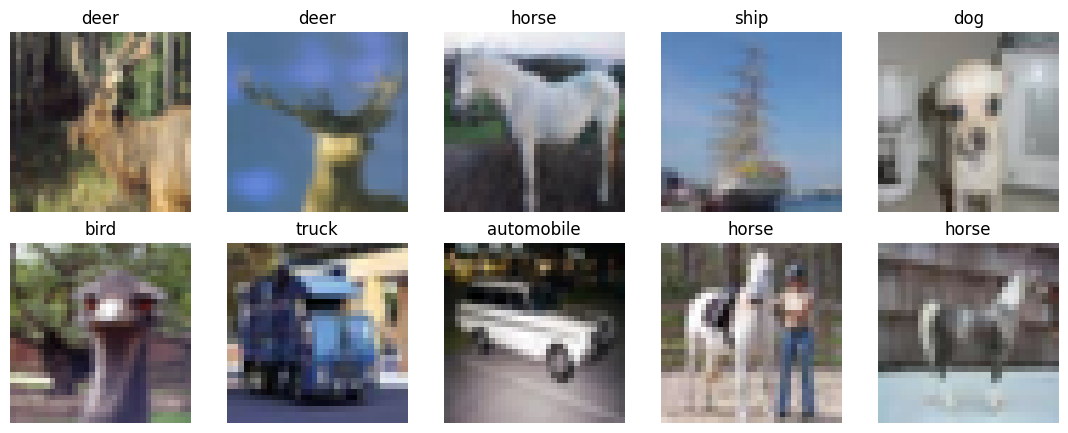

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets

(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

val_ratio = 0.1
num_val = int(len(x_train) * val_ratio)
x_val, y_val = x_train[:num_val], y_train[:num_val]
x_train, y_train = x_train[num_val:], y_train[num_val:]

class_names = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

def show_samples(images, labels, rows=2, cols=5, class_names=class_names, seed=42):
    np.random.seed(seed)
    idxs = np.random.choice(len(images), size=rows*cols, replace=False)
    plt.figure(figsize=(cols*2.2, rows*2.2))
    for i, idx in enumerate(idxs):
        plt.subplot(rows, cols, i+1)
        plt.imshow(images[idx])
        plt.title(class_names[int(labels[idx][0])])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(x_train, y_train, rows=2, cols=5)


---

### Parte 2 - Modelo Base ANN

In [2]:
import time
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

tf.random.set_seed(42)

ann = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    layers.Flatten(),                             
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(10, activation="softmax")
])

ann.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

early = callbacks.EarlyStopping(
    monitor="val_accuracy", patience=5, restore_best_weights=True
)

start = time.time()
hist_ann = ann.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[early],
    verbose=1
)
train_time_s = time.time() - start

print(f"Tiempo de entrenamiento ANN: {train_time_s:.1f} s")

test_loss, test_acc = ann.evaluate(x_test, y_test, verbose=0)
print(f"ANN - Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")


Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.2357 - loss: 2.0569 - val_accuracy: 0.3114 - val_loss: 1.8934
Epoch 2/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2866 - loss: 1.9264 - val_accuracy: 0.3416 - val_loss: 1.8419
Epoch 3/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3016 - loss: 1.8931 - val_accuracy: 0.3786 - val_loss: 1.7953
Epoch 4/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3136 - loss: 1.8682 - val_accuracy: 0.3906 - val_loss: 1.7714
Epoch 5/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3233 - loss: 1.8441 - val_accuracy: 0.3776 - val_loss: 1.7666
Epoch 6/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3270 - loss: 1.8325 - val_accuracy: 0.3876 - val_loss: 1.7374
Epoch 7/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3424 - loss: 1.8108 - val_accuracy: 0.3950 - val_loss: 1.7226
Epoch 8/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3449 - loss: 1.7950 - val_accuracy: 0.

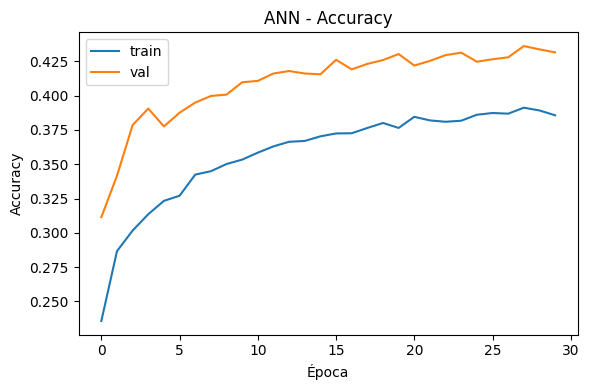

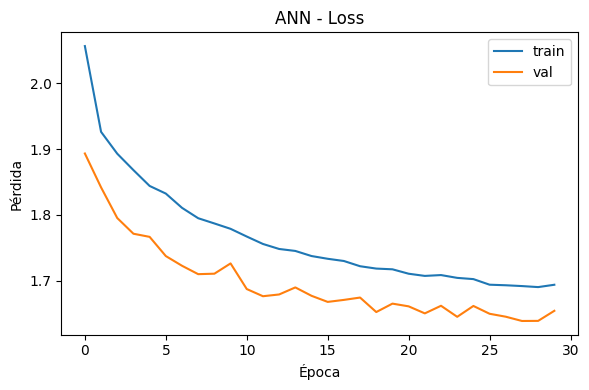

In [3]:
import matplotlib.pyplot as plt

def plot_history(h, title_prefix="ANN"):
    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(h.history["accuracy"], label="train")
    plt.plot(h.history["val_accuracy"], label="val")
    plt.xlabel("Época"); plt.ylabel("Accuracy"); plt.title(f"{title_prefix} - Accuracy")
    plt.legend(); plt.tight_layout(); plt.show()

    # Pérdida
    plt.figure(figsize=(6,4))
    plt.plot(h.history["loss"], label="train")
    plt.plot(h.history["val_loss"], label="val")
    plt.xlabel("Época"); plt.ylabel("Pérdida"); plt.title(f"{title_prefix} - Loss")
    plt.legend(); plt.tight_layout(); plt.show()

plot_history(hist_ann, "ANN")


----

### Parte 3 - Implementación de CNN 


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import time

tf.random.set_seed(42)

cnn = models.Sequential([
    layers.Input(shape=(32, 32, 3)),

    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")
])

cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

cnn.summary()

early = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=7,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

start = time.time()
hist_cnn = cnn.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=40,
    batch_size=64,
    callbacks=[early, reduce_lr],
    verbose=1
)
train_time_cnn = time.time() - start
print(f"Tiempo de entrenamiento CNN: {train_time_cnn:.1f} s")

test_loss_cnn, test_acc_cnn = cnn.evaluate(x_test, y_test, verbose=0)
print(f"CNN - Test Accuracy: {test_acc_cnn:.4f} | Test Loss: {test_loss_cnn:.4f}")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 402,986 (1.54 MB)

 Trainable params: 402,986 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 44s 61ms/step - accuracy: 0.3367 - loss: 1.7912 - val_accuracy: 0.5238 - val_loss: 1.3373 - learning_rate: 0.0010
Epoch 2/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 44s 62ms/step - accuracy: 0.5120 - loss: 1.3452 - val_accuracy: 0.5980 - val_loss: 1.1757 - learning_rate: 0.0010
Epoch 3/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - accuracy: 0.5844 - loss: 1.1738 - val_accuracy: 0.6582 - val_loss: 0.9815 - learning_rate: 0.0010
Epoch 4/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - accuracy: 0.6245 - loss: 1.0753 - val_accuracy: 0.6706 - val_loss: 0.9137 - learning_rate: 0.0010
Epoch 5/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - accuracy: 0.6500 - loss: 0.9906 - val_accuracy: 0.7084 - val_loss: 0.8229 - learning_rate: 0.0010
Epoch 6/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - accuracy: 0.6773 - loss: 0.9269 - val_accuracy: 0.7296 - val_loss: 0.7577 - learning_rate: 0.0010
Epoch 7/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.6964 - l

KeyboardInterrupt: 

In [ ]:
plot_history(hist_cnn, "CNN")